This notebook is accompanied with a [series of blog posts](https://medium.com/@margaretmz/selfie2anime-with-tflite-part-1-overview-f97500800ffe). To follow along with this Colab Notebook we recommend that you also read [this blog post](https://medium.com/@margaretmz/selfie2anime-with-tflite-part-2-tflite-model-84002cf521dc).

**Authors**: [Margaret Maynard-Reid](https://twitter.com/margaretmz), [Sayak Paul](https://twitter.com/RisingSayak) 

Shoutout to Khanh LeViet and Lu Wang from the TensorFlow Lite team for their guidance. Main codebase of UGATIT is here: https://github.com/taki0112/UGATIT. 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/margaretmz/selfie2anime-e2e-tutorial/blob/master/ml/Selfie2Anime_Model_Conversion_50_Epochs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/margaretmz/selfie2anime-e2e-tutorial/tree/master/ml/Selfie2Anime_Model_Conversion_50_Epochs.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Initial setup

In [ ]:
!pip install tensorflow==1.14
import tensorflow as tf
print(tf.__version__)

You can safely ignore the warnings. 

In [ ]:
import os
import tempfile

## Loading the checkpoints

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials.

In [ ]:
os.environ['KAGGLE_USERNAME'] = "" # TODO: enter your Kaggle user name here
os.environ['KAGGLE_KEY'] = "" # TODO: enter your Kaggle key here

In [ ]:
!kaggle datasets download -d t04glovern/ugatit-selfie2anime-pretrained
!unzip -qq /content/ugatit-selfie2anime-pretrained.zip

 99% 1.39G/1.40G [00:18<00:00, 80.7MB/s]
100% 1.40G/1.40G [00:18<00:00, 82.2MB/s]


## Some utils

In [ ]:
!git clone https://github.com/taki0112/UGATIT
%cd UGATIT

Cloning into 'UGATIT'...
remote: Enumerating objects: 171, done.
remote: Total 171 (delta 0), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (171/171), 5.68 MiB | 35.22 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/UGATIT


In [ ]:
# Reference: https://dev.to/0xbf/use-dot-syntax-to-access-dictionary-key-python-tips-10ec
class DictX(dict):
    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __setattr__(self, key, value):
        self[key] = value

    def __delattr__(self, key):
        try:
            del self[key]
        except KeyError as k:
            raise AttributeError(k)

    def __repr__(self):
        return '<DictX ' + dict.__repr__(self) + '>'

In [ ]:
# This is needed just to initialize `UGATIT` class
args = 	dict(phase='test',
	light=True,
	dataset='selfie2anime',
	epoch=100,
	iteration=10000,
	batch_size=1,
	print_freq=1000,
	save_freq=1000,
	decay_flag=True,
	decay_epoch=50,
	lr=0.0001,
	GP_ld=10,
	adv_weight=1,
	cycle_weight=10,
	identity_weight=10,
	cam_weight=1000,
	gan_type='lsgan',
	smoothing=True,
	ch=64,
	n_res=4,
	n_dis=6,
	n_critic=1,
	sn=True,
	img_size=256,
	img_ch=3,
	augment_flag=False,
	checkpoint_dir='/content',
	result_dir='/content',
	log_dir='/content',
	sample_dir='/content')

In [ ]:
# Wrap the arguments in a dictionary because this particular format is required 
# in order to instantiate the `UGATIT` class
data = DictX(args)

## UGATIT class for convenience

Run this block of code to get access to some helper functions. Otherwise, the rest of this Colab may not run correctly.

In [ ]:
#@title
from ops import *
from utils import *
from glob import glob
import time
from tensorflow.contrib.data import prefetch_to_device, shuffle_and_repeat, map_and_batch
import numpy as np

class UGATIT(object) :
    def __init__(self, sess, args):
        self.light = args.light

        if self.light :
            self.model_name = 'UGATIT_light'
        else :
            self.model_name = 'UGATIT'

        self.sess = sess
        self.phase = args.phase
        self.checkpoint_dir = args.checkpoint_dir
        self.result_dir = args.result_dir
        self.log_dir = args.log_dir
        self.dataset_name = args.dataset
        self.augment_flag = args.augment_flag

        self.epoch = args.epoch
        self.iteration = args.iteration
        self.decay_flag = args.decay_flag
        self.decay_epoch = args.decay_epoch

        self.gan_type = args.gan_type

        self.batch_size = args.batch_size
        self.print_freq = args.print_freq
        self.save_freq = args.save_freq

        self.init_lr = args.lr
        self.ch = args.ch

        """ Weight """
        self.adv_weight = args.adv_weight
        self.cycle_weight = args.cycle_weight
        self.identity_weight = args.identity_weight
        self.cam_weight = args.cam_weight
        self.ld = args.GP_ld
        self.smoothing = args.smoothing

        """ Generator """
        self.n_res = args.n_res

        """ Discriminator """
        self.n_dis = args.n_dis
        self.n_critic = args.n_critic
        self.sn = args.sn

        self.img_size = args.img_size
        self.img_ch = args.img_ch


        self.sample_dir = os.path.join(args.sample_dir, self.model_dir)
        check_folder(self.sample_dir)

        # self.trainA, self.trainB = prepare_data(dataset_name=self.dataset_name, size=self.img_size
        self.trainA_dataset = glob('./dataset/{}/*.*'.format(self.dataset_name + '/trainA'))
        self.trainB_dataset = glob('./dataset/{}/*.*'.format(self.dataset_name + '/trainB'))
        self.dataset_num = max(len(self.trainA_dataset), len(self.trainB_dataset))

        print()

        print("##### Information #####")
        print("# light : ", self.light)
        print("# gan type : ", self.gan_type)
        print("# dataset : ", self.dataset_name)
        print("# max dataset number : ", self.dataset_num)
        print("# batch_size : ", self.batch_size)
        print("# epoch : ", self.epoch)
        print("# iteration per epoch : ", self.iteration)
        print("# smoothing : ", self.smoothing)

        print()

        print("##### Generator #####")
        print("# residual blocks : ", self.n_res)

        print()

        print("##### Discriminator #####")
        print("# discriminator layer : ", self.n_dis)
        print("# the number of critic : ", self.n_critic)
        print("# spectral normalization : ", self.sn)

        print()

        print("##### Weight #####")
        print("# adv_weight : ", self.adv_weight)
        print("# cycle_weight : ", self.cycle_weight)
        print("# identity_weight : ", self.identity_weight)
        print("# cam_weight : ", self.cam_weight)

    ##################################################################################
    # Generator
    ##################################################################################

    def generator(self, x_init, reuse=False, scope="generator"):
        channel = self.ch
        with tf.variable_scope(scope, reuse=reuse) :
            x = conv(x_init, channel, kernel=7, stride=1, pad=3, pad_type='reflect', scope='conv')
            x = instance_norm(x, scope='ins_norm')
            x = relu(x)

            # Down-Sampling
            for i in range(2) :
                x = conv(x, channel*2, kernel=3, stride=2, pad=1, pad_type='reflect', scope='conv_'+str(i))
                x = instance_norm(x, scope='ins_norm_'+str(i))
                x = relu(x)

                channel = channel * 2

            # Down-Sampling Bottleneck
            for i in range(self.n_res):
                x = resblock(x, channel, scope='resblock_' + str(i))


            # Class Activation Map
            cam_x = global_avg_pooling(x)
            cam_gap_logit, cam_x_weight = fully_connected_with_w(cam_x, scope='CAM_logit')
            x_gap = tf.multiply(x, cam_x_weight)

            cam_x = global_max_pooling(x)
            cam_gmp_logit, cam_x_weight = fully_connected_with_w(cam_x, reuse=True, scope='CAM_logit')
            x_gmp = tf.multiply(x, cam_x_weight)


            cam_logit = tf.concat([cam_gap_logit, cam_gmp_logit], axis=-1)
            x = tf.concat([x_gap, x_gmp], axis=-1)

            x = conv(x, channel, kernel=1, stride=1, scope='conv_1x1')
            x = relu(x)

            heatmap = tf.squeeze(tf.reduce_sum(x, axis=-1))

            # Gamma, Beta block
            gamma, beta = self.MLP(x, reuse=reuse)

            # Up-Sampling Bottleneck
            for i in range(self.n_res):
                x = adaptive_ins_layer_resblock(x, channel, gamma, beta, smoothing=self.smoothing, scope='adaptive_resblock' + str(i))

            # Up-Sampling
            for i in range(2) :
                x = up_sample(x, scale_factor=2)
                x = conv(x, channel//2, kernel=3, stride=1, pad=1, pad_type='reflect', scope='up_conv_'+str(i))
                x = layer_instance_norm(x, scope='layer_ins_norm_'+str(i))
                x = relu(x)

                channel = channel // 2


            x = conv(x, channels=3, kernel=7, stride=1, pad=3, pad_type='reflect', scope='G_logit')
            x = tanh(x)

            return x, cam_logit, heatmap

    def MLP(self, x, use_bias=True, reuse=False, scope='MLP'):
        channel = self.ch * self.n_res

        if self.light :
            x = global_avg_pooling(x)

        with tf.variable_scope(scope, reuse=reuse):
            for i in range(2) :
                x = fully_connected(x, channel, use_bias, scope='linear_' + str(i))
                x = relu(x)


            gamma = fully_connected(x, channel, use_bias, scope='gamma')
            beta = fully_connected(x, channel, use_bias, scope='beta')

            gamma = tf.reshape(gamma, shape=[self.batch_size, 1, 1, channel])
            beta = tf.reshape(beta, shape=[self.batch_size, 1, 1, channel])

            return gamma, beta

    ##################################################################################
    # Discriminator
    ##################################################################################

    def discriminator(self, x_init, reuse=False, scope="discriminator"):
        D_logit = []
        D_CAM_logit = []
        with tf.variable_scope(scope, reuse=reuse) :
            local_x, local_cam, local_heatmap = self.discriminator_local(x_init, reuse=reuse, scope='local')
            global_x, global_cam, global_heatmap = self.discriminator_global(x_init, reuse=reuse, scope='global')

            D_logit.extend([local_x, global_x])
            D_CAM_logit.extend([local_cam, global_cam])

            return D_logit, D_CAM_logit, local_heatmap, global_heatmap

    def discriminator_global(self, x_init, reuse=False, scope='discriminator_global'):
        with tf.variable_scope(scope, reuse=reuse):
            channel = self.ch
            x = conv(x_init, channel, kernel=4, stride=2, pad=1, pad_type='reflect', sn=self.sn, scope='conv_0')
            x = lrelu(x, 0.2)

            for i in range(1, self.n_dis - 1):
                x = conv(x, channel * 2, kernel=4, stride=2, pad=1, pad_type='reflect', sn=self.sn, scope='conv_' + str(i))
                x = lrelu(x, 0.2)

                channel = channel * 2

            x = conv(x, channel * 2, kernel=4, stride=1, pad=1, pad_type='reflect', sn=self.sn, scope='conv_last')
            x = lrelu(x, 0.2)

            channel = channel * 2

            cam_x = global_avg_pooling(x)
            cam_gap_logit, cam_x_weight = fully_connected_with_w(cam_x, sn=self.sn, scope='CAM_logit')
            x_gap = tf.multiply(x, cam_x_weight)

            cam_x = global_max_pooling(x)
            cam_gmp_logit, cam_x_weight = fully_connected_with_w(cam_x, sn=self.sn, reuse=True, scope='CAM_logit')
            x_gmp = tf.multiply(x, cam_x_weight)

            cam_logit = tf.concat([cam_gap_logit, cam_gmp_logit], axis=-1)
            x = tf.concat([x_gap, x_gmp], axis=-1)

            x = conv(x, channel, kernel=1, stride=1, scope='conv_1x1')
            x = lrelu(x, 0.2)

            heatmap = tf.squeeze(tf.reduce_sum(x, axis=-1))


            x = conv(x, channels=1, kernel=4, stride=1, pad=1, pad_type='reflect', sn=self.sn, scope='D_logit')

            return x, cam_logit, heatmap

    def discriminator_local(self, x_init, reuse=False, scope='discriminator_local'):
        with tf.variable_scope(scope, reuse=reuse) :
            channel = self.ch
            x = conv(x_init, channel, kernel=4, stride=2, pad=1, pad_type='reflect', sn=self.sn, scope='conv_0')
            x = lrelu(x, 0.2)

            for i in range(1, self.n_dis - 2 - 1):
                x = conv(x, channel * 2, kernel=4, stride=2, pad=1, pad_type='reflect', sn=self.sn, scope='conv_' + str(i))
                x = lrelu(x, 0.2)

                channel = channel * 2

            x = conv(x, channel * 2, kernel=4, stride=1, pad=1, pad_type='reflect', sn=self.sn, scope='conv_last')
            x = lrelu(x, 0.2)

            channel = channel * 2

            cam_x = global_avg_pooling(x)
            cam_gap_logit, cam_x_weight = fully_connected_with_w(cam_x, sn=self.sn, scope='CAM_logit')
            x_gap = tf.multiply(x, cam_x_weight)

            cam_x = global_max_pooling(x)
            cam_gmp_logit, cam_x_weight = fully_connected_with_w(cam_x, sn=self.sn, reuse=True, scope='CAM_logit')
            x_gmp = tf.multiply(x, cam_x_weight)

            cam_logit = tf.concat([cam_gap_logit, cam_gmp_logit], axis=-1)
            x = tf.concat([x_gap, x_gmp], axis=-1)

            x = conv(x, channel, kernel=1, stride=1, scope='conv_1x1')
            x = lrelu(x, 0.2)

            heatmap = tf.squeeze(tf.reduce_sum(x, axis=-1))

            x = conv(x, channels=1, kernel=4, stride=1, pad=1, pad_type='reflect', sn=self.sn, scope='D_logit')

            return x, cam_logit, heatmap

    ##################################################################################
    # Model
    ##################################################################################

    def generate_a2b(self, x_A, reuse=False):
        out, cam, _ = self.generator(x_A, reuse=reuse, scope="generator_B")

        return out, cam

    def generate_b2a(self, x_B, reuse=False):
        out, cam, _ = self.generator(x_B, reuse=reuse, scope="generator_A")

        return out, cam

    def discriminate_real(self, x_A, x_B):
        real_A_logit, real_A_cam_logit, _, _ = self.discriminator(x_A, scope="discriminator_A")
        real_B_logit, real_B_cam_logit, _, _ = self.discriminator(x_B, scope="discriminator_B")

        return real_A_logit, real_A_cam_logit, real_B_logit, real_B_cam_logit

    def discriminate_fake(self, x_ba, x_ab):
        fake_A_logit, fake_A_cam_logit, _, _ = self.discriminator(x_ba, reuse=True, scope="discriminator_A")
        fake_B_logit, fake_B_cam_logit, _, _ = self.discriminator(x_ab, reuse=True, scope="discriminator_B")

        return fake_A_logit, fake_A_cam_logit, fake_B_logit, fake_B_cam_logit

    def gradient_panalty(self, real, fake, scope="discriminator_A"):
        if self.gan_type.__contains__('dragan'):
            eps = tf.random_uniform(shape=tf.shape(real), minval=0., maxval=1.)
            _, x_var = tf.nn.moments(real, axes=[0, 1, 2, 3])
            x_std = tf.sqrt(x_var)  # magnitude of noise decides the size of local region

            fake = real + 0.5 * x_std * eps

        alpha = tf.random_uniform(shape=[self.batch_size, 1, 1, 1], minval=0., maxval=1.)
        interpolated = real + alpha * (fake - real)

        logit, cam_logit, _, _ = self.discriminator(interpolated, reuse=True, scope=scope)


        GP = []
        cam_GP = []

        for i in range(2) :
            grad = tf.gradients(logit[i], interpolated)[0] # gradient of D(interpolated)
            grad_norm = tf.norm(flatten(grad), axis=1) # l2 norm

            # WGAN - LP
            if self.gan_type == 'wgan-lp' :
                GP.append(self.ld * tf.reduce_mean(tf.square(tf.maximum(0.0, grad_norm - 1.))))

            elif self.gan_type == 'wgan-gp' or self.gan_type == 'dragan':
                GP.append(self.ld * tf.reduce_mean(tf.square(grad_norm - 1.)))

        for i in range(2) :
            grad = tf.gradients(cam_logit[i], interpolated)[0] # gradient of D(interpolated)
            grad_norm = tf.norm(flatten(grad), axis=1) # l2 norm

            # WGAN - LP
            if self.gan_type == 'wgan-lp' :
                cam_GP.append(self.ld * tf.reduce_mean(tf.square(tf.maximum(0.0, grad_norm - 1.))))

            elif self.gan_type == 'wgan-gp' or self.gan_type == 'dragan':
                cam_GP.append(self.ld * tf.reduce_mean(tf.square(grad_norm - 1.)))


        return sum(GP), sum(cam_GP)

    def build_model(self):
        if self.phase == 'train' :
            self.lr = tf.placeholder(tf.float32, name='learning_rate')


            """ Input Image"""
            Image_Data_Class = ImageData(self.img_size, self.img_ch, self.augment_flag)

            trainA = tf.data.Dataset.from_tensor_slices(self.trainA_dataset)
            trainB = tf.data.Dataset.from_tensor_slices(self.trainB_dataset)


            gpu_device = '/gpu:0'
            trainA = trainA.apply(shuffle_and_repeat(self.dataset_num)).apply(map_and_batch(Image_Data_Class.image_processing, self.batch_size, num_parallel_batches=16, drop_remainder=True)).apply(prefetch_to_device(gpu_device, None))
            trainB = trainB.apply(shuffle_and_repeat(self.dataset_num)).apply(map_and_batch(Image_Data_Class.image_processing, self.batch_size, num_parallel_batches=16, drop_remainder=True)).apply(prefetch_to_device(gpu_device, None))


            trainA_iterator = trainA.make_one_shot_iterator()
            trainB_iterator = trainB.make_one_shot_iterator()

            self.domain_A = trainA_iterator.get_next()
            self.domain_B = trainB_iterator.get_next()

            """ Define Generator, Discriminator """
            x_ab, cam_ab = self.generate_a2b(self.domain_A) # real a
            x_ba, cam_ba = self.generate_b2a(self.domain_B) # real b

            x_aba, _ = self.generate_b2a(x_ab, reuse=True) # real b
            x_bab, _ = self.generate_a2b(x_ba, reuse=True) # real a

            x_aa, cam_aa = self.generate_b2a(self.domain_A, reuse=True) # fake b
            x_bb, cam_bb = self.generate_a2b(self.domain_B, reuse=True) # fake a

            real_A_logit, real_A_cam_logit, real_B_logit, real_B_cam_logit = self.discriminate_real(self.domain_A, self.domain_B)
            fake_A_logit, fake_A_cam_logit, fake_B_logit, fake_B_cam_logit = self.discriminate_fake(x_ba, x_ab)


            """ Define Loss """
            if self.gan_type.__contains__('wgan') or self.gan_type == 'dragan' :
                GP_A, GP_CAM_A = self.gradient_panalty(real=self.domain_A, fake=x_ba, scope="discriminator_A")
                GP_B, GP_CAM_B = self.gradient_panalty(real=self.domain_B, fake=x_ab, scope="discriminator_B")
            else :
                GP_A, GP_CAM_A  = 0, 0
                GP_B, GP_CAM_B = 0, 0

            G_ad_loss_A = (generator_loss(self.gan_type, fake_A_logit) + generator_loss(self.gan_type, fake_A_cam_logit))
            G_ad_loss_B = (generator_loss(self.gan_type, fake_B_logit) + generator_loss(self.gan_type, fake_B_cam_logit))

            D_ad_loss_A = (discriminator_loss(self.gan_type, real_A_logit, fake_A_logit) + discriminator_loss(self.gan_type, real_A_cam_logit, fake_A_cam_logit) + GP_A + GP_CAM_A)
            D_ad_loss_B = (discriminator_loss(self.gan_type, real_B_logit, fake_B_logit) + discriminator_loss(self.gan_type, real_B_cam_logit, fake_B_cam_logit) + GP_B + GP_CAM_B)

            reconstruction_A = L1_loss(x_aba, self.domain_A) # reconstruction
            reconstruction_B = L1_loss(x_bab, self.domain_B) # reconstruction

            identity_A = L1_loss(x_aa, self.domain_A)
            identity_B = L1_loss(x_bb, self.domain_B)

            cam_A = cam_loss(source=cam_ba, non_source=cam_aa)
            cam_B = cam_loss(source=cam_ab, non_source=cam_bb)

            Generator_A_gan = self.adv_weight * G_ad_loss_A
            Generator_A_cycle = self.cycle_weight * reconstruction_B
            Generator_A_identity = self.identity_weight * identity_A
            Generator_A_cam = self.cam_weight * cam_A


            Generator_B_gan = self.adv_weight * G_ad_loss_B
            Generator_B_cycle = self.cycle_weight * reconstruction_A
            Generator_B_identity = self.identity_weight * identity_B
            Generator_B_cam = self.cam_weight * cam_B


            Generator_A_loss = Generator_A_gan + Generator_A_cycle + Generator_A_identity + Generator_A_cam
            Generator_B_loss = Generator_B_gan + Generator_B_cycle + Generator_B_identity + Generator_B_cam


            Discriminator_A_loss = self.adv_weight * D_ad_loss_A
            Discriminator_B_loss = self.adv_weight * D_ad_loss_B

            self.Generator_loss = Generator_A_loss + Generator_B_loss + regularization_loss('generator')
            self.Discriminator_loss = Discriminator_A_loss + Discriminator_B_loss + regularization_loss('discriminator')


            """ Result Image """
            self.fake_A = x_ba
            self.fake_B = x_ab

            self.real_A = self.domain_A
            self.real_B = self.domain_B


            """ Training """
            t_vars = tf.trainable_variables()
            G_vars = [var for var in t_vars if 'generator' in var.name]
            D_vars = [var for var in t_vars if 'discriminator' in var.name]

            self.G_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5, beta2=0.999).minimize(self.Generator_loss, var_list=G_vars)
            self.D_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5, beta2=0.999).minimize(self.Discriminator_loss, var_list=D_vars)


            """" Summary """
            self.all_G_loss = tf.summary.scalar("Generator_loss", self.Generator_loss)
            self.all_D_loss = tf.summary.scalar("Discriminator_loss", self.Discriminator_loss)

            self.G_A_loss = tf.summary.scalar("G_A_loss", Generator_A_loss)
            self.G_A_gan = tf.summary.scalar("G_A_gan", Generator_A_gan)
            self.G_A_cycle = tf.summary.scalar("G_A_cycle", Generator_A_cycle)
            self.G_A_identity = tf.summary.scalar("G_A_identity", Generator_A_identity)
            self.G_A_cam = tf.summary.scalar("G_A_cam", Generator_A_cam)

            self.G_B_loss = tf.summary.scalar("G_B_loss", Generator_B_loss)
            self.G_B_gan = tf.summary.scalar("G_B_gan", Generator_B_gan)
            self.G_B_cycle = tf.summary.scalar("G_B_cycle", Generator_B_cycle)
            self.G_B_identity = tf.summary.scalar("G_B_identity", Generator_B_identity)
            self.G_B_cam = tf.summary.scalar("G_B_cam", Generator_B_cam)

            self.D_A_loss = tf.summary.scalar("D_A_loss", Discriminator_A_loss)
            self.D_B_loss = tf.summary.scalar("D_B_loss", Discriminator_B_loss)

            self.rho_var = []
            for var in tf.trainable_variables():
                if 'rho' in var.name:
                    self.rho_var.append(tf.summary.histogram(var.name, var))
                    self.rho_var.append(tf.summary.scalar(var.name + "_min", tf.reduce_min(var)))
                    self.rho_var.append(tf.summary.scalar(var.name + "_max", tf.reduce_max(var)))
                    self.rho_var.append(tf.summary.scalar(var.name + "_mean", tf.reduce_mean(var)))

            g_summary_list = [self.G_A_loss, self.G_A_gan, self.G_A_cycle, self.G_A_identity, self.G_A_cam,
                              self.G_B_loss, self.G_B_gan, self.G_B_cycle, self.G_B_identity, self.G_B_cam,
                              self.all_G_loss]

            g_summary_list.extend(self.rho_var)
            d_summary_list = [self.D_A_loss, self.D_B_loss, self.all_D_loss]

            self.G_loss = tf.summary.merge(g_summary_list)
            self.D_loss = tf.summary.merge(d_summary_list)

        else :
            """ Test """
            self.test_domain_A = tf.placeholder(tf.float32, [1, self.img_size, self.img_size, self.img_ch], name='test_domain_A')
            self.test_domain_B = tf.placeholder(tf.float32, [1, self.img_size, self.img_size, self.img_ch], name='test_domain_B')


            self.test_fake_B, _ = self.generate_a2b(self.test_domain_A)
            self.test_fake_A, _ = self.generate_b2a(self.test_domain_B)


    def train(self):
        # initialize all variables
        tf.global_variables_initializer().run()

        # saver to save model
        self.saver = tf.train.Saver()

        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '/' + self.model_dir, self.sess.graph)


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.iteration)
            start_batch_id = checkpoint_counter - start_epoch * self.iteration
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [!] Load failed...")

        # loop for epoch
        start_time = time.time()
        past_g_loss = -1.
        lr = self.init_lr
        for epoch in range(start_epoch, self.epoch):
            # lr = self.init_lr if epoch < self.decay_epoch else self.init_lr * (self.epoch - epoch) / (self.epoch - self.decay_epoch)
            if self.decay_flag :
                #lr = self.init_lr * pow(0.5, epoch // self.decay_epoch)
                lr = self.init_lr if epoch < self.decay_epoch else self.init_lr * (self.epoch - epoch) / (self.epoch - self.decay_epoch)
            for idx in range(start_batch_id, self.iteration):
                train_feed_dict = {
                    self.lr : lr
                }

                # Update D
                _, d_loss, summary_str = self.sess.run([self.D_optim,
                                                        self.Discriminator_loss, self.D_loss], feed_dict = train_feed_dict)
                self.writer.add_summary(summary_str, counter)

                # Update G
                g_loss = None
                if (counter - 1) % self.n_critic == 0 :
                    batch_A_images, batch_B_images, fake_A, fake_B, _, g_loss, summary_str = self.sess.run([self.real_A, self.real_B,
                                                                                                            self.fake_A, self.fake_B,
                                                                                                            self.G_optim,
                                                                                                            self.Generator_loss, self.G_loss], feed_dict = train_feed_dict)
                    self.writer.add_summary(summary_str, counter)
                    past_g_loss = g_loss

                # display training status
                counter += 1
                if g_loss == None :
                    g_loss = past_g_loss
                print("Epoch: [%2d] [%5d/%5d] time: %4.4f d_loss: %.8f, g_loss: %.8f" % (epoch, idx, self.iteration, time.time() - start_time, d_loss, g_loss))

                if np.mod(idx+1, self.print_freq) == 0 :
                    save_images(batch_A_images, [self.batch_size, 1],
                                './{}/real_A_{:03d}_{:05d}.png'.format(self.sample_dir, epoch, idx+1))
                    # save_images(batch_B_images, [self.batch_size, 1],
                    #             './{}/real_B_{:03d}_{:05d}.png'.format(self.sample_dir, epoch, idx+1))

                    # save_images(fake_A, [self.batch_size, 1],
                    #             './{}/fake_A_{:03d}_{:05d}.png'.format(self.sample_dir, epoch, idx+1))
                    save_images(fake_B, [self.batch_size, 1],
                                './{}/fake_B_{:03d}_{:05d}.png'.format(self.sample_dir, epoch, idx+1))

                if np.mod(idx + 1, self.save_freq) == 0:
                    self.save(self.checkpoint_dir, counter)



            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0

            # save model for final step
            self.save(self.checkpoint_dir, counter)

    @property
    def model_dir(self):
        n_res = str(self.n_res) + 'resblock'
        n_dis = str(self.n_dis) + 'dis'

        if self.smoothing :
            smoothing = '_smoothing'
        else :
            smoothing = ''

        if self.sn :
            sn = '_sn'
        else :
            sn = ''

        return "{}_{}_{}_{}_{}_{}_{}_{}_{}_{}{}{}".format(self.model_name, self.dataset_name,
                                                         self.gan_type, n_res, n_dis,
                                                         self.n_critic,
                                                         self.adv_weight, self.cycle_weight, self.identity_weight, self.cam_weight, sn, smoothing)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess, os.path.join(checkpoint_dir, self.model_name + '.model'), global_step=step)

    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(ckpt_name.split('-')[-1])
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

    def test(self):
        tf.global_variables_initializer().run()
        test_A_files = glob('./dataset/{}/*.*'.format(self.dataset_name + '/testA'))
        test_B_files = glob('./dataset/{}/*.*'.format(self.dataset_name + '/testB'))

        self.saver = tf.train.Saver()
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        self.result_dir = os.path.join(self.result_dir, self.model_dir)
        check_folder(self.result_dir)

        if could_load :
            print(" [*] Load SUCCESS")
        else :
            print(" [!] Load failed...")

        # write html for visual comparison
        index_path = os.path.join(self.result_dir, 'index.html')
        index = open(index_path, 'w')
        index.write("<html><body><table><tr>")
        index.write("<th>name</th><th>input</th><th>output</th></tr>")

        for sample_file  in test_A_files : # A -> B
            print('Processing A image: ' + sample_file)
            sample_image = np.asarray(load_test_data(sample_file, size=self.img_size))
            image_path = os.path.join(self.result_dir,'{0}'.format(os.path.basename(sample_file)))

            fake_img = self.sess.run(self.test_fake_B, feed_dict = {self.test_domain_A : sample_image})
            save_images(fake_img, [1, 1], image_path)

            index.write("<td>%s</td>" % os.path.basename(image_path))

            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (sample_file if os.path.isabs(sample_file) else (
                '../..' + os.path.sep + sample_file), self.img_size, self.img_size))
            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (image_path if os.path.isabs(image_path) else (
                '../..' + os.path.sep + image_path), self.img_size, self.img_size))
            index.write("</tr>")

        for sample_file  in test_B_files : # B -> A
            print('Processing B image: ' + sample_file)
            sample_image = np.asarray(load_test_data(sample_file, size=self.img_size))
            image_path = os.path.join(self.result_dir,'{0}'.format(os.path.basename(sample_file)))

            fake_img = self.sess.run(self.test_fake_A, feed_dict = {self.test_domain_B : sample_image})

            save_images(fake_img, [1, 1], image_path)
            index.write("<td>%s</td>" % os.path.basename(image_path))
            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (sample_file if os.path.isabs(sample_file) else (
                    '../..' + os.path.sep + sample_file), self.img_size, self.img_size))
            index.write("<td><img src='%s' width='%d' height='%d'></td>" % (image_path if os.path.isabs(image_path) else (
                    '../..' + os.path.sep + image_path), self.img_size, self.img_size))
            index.write("</tr>")
        index.close()

## Build and initialize the model

[Reference](https://github.com/tensorflow/magenta/blob/85ef5267513f62f4a40b01b2a1ee488f90f64a13/magenta/models/arbitrary_image_stylization/arbitrary_image_stylization_convert_tflite.py#L46) of the following utility. 

In [ ]:
def load_checkpoint(sess, checkpoint):
  """Loads a checkpoint file into the session.
  Args:
    sess: tf.Session, the TF session to load variables from the checkpoint to.
    checkpoint: str, path to the checkpoint file.
  """
  model_saver = tf.train.Saver(tf.global_variables())
  checkpoint = os.path.expanduser(checkpoint)
  if tf.gfile.IsDirectory(checkpoint):
    checkpoint = tf.train.latest_checkpoint(checkpoint)
    tf.logging.info('loading latest checkpoint file: {}'.format(checkpoint))
  model_saver.restore(sess, checkpoint)

## Exporting to `SavedModel`

Note that we will only be using the `Selfie2Anime` variant. 

In [ ]:
saved_model_dir = tempfile.mkdtemp()

with tf.Graph().as_default(), tf.Session() as sess:
    gan = UGATIT(sess, data)
    gan.build_model()
    load_checkpoint(sess, '/content/checkpoint/UGATIT_light_selfie2anime_lsgan_4resblock_6dis_1_1_10_10_1000_sn_smoothing')
    
    # Write SavedModel for serving or conversion to TF Lite
    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={
            gan.test_domain_A.name: gan.test_domain_A,
        },
        outputs={gan.test_fake_B.name: gan.test_fake_B})
    tf.logging.debug('Export transform SavedModel to',
                     saved_model_dir)


##### Information #####
# light :  True
# gan type :  lsgan
# dataset :  selfie2anime
# max dataset number :  0
# batch_size :  1
# epoch :  100
# iteration per epoch :  10000
# smoothing :  True

##### Generator #####
# residual blocks :  4

##### Discriminator #####
# discriminator layer :  6
# the number of critic :  1
# spectral normalization :  True

##### Weight #####
# adv_weight :  1
# cycle_weight :  10
# identity_weight :  10
# cam_weight :  1000

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use keras.layers.dense instead.

INFO:tensorflow:loading latest checkpoint file: /content/checkpoint/UGATIT_light_selfie2anime_lsgan_4resblock_6dis_1_1_10_10_1000_sn_smoothing/UGATIT_light.model-214000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/checkpoint/UGATIT_light_selfie2anime_lsgan_

Note the path of the `SavedModel` from the above logs. We will be needing this for the subsequent steps. The warnings can be ignored. 

In [ ]:
# Inspecting model size
print(os.path.getsize(os.path.join(saved_model_dir, 'saved_model.pb')))

836480


## TF Lite conversion

In [ ]:
!pip install -q tensorflow==2.2.0

**Important**: Restart the runtime by selecting menu item, Runtime > Restart runtime.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
def convert_to_tflite(saved_model_path, tflite_model_path):
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    concrete_func.outputs[0].set_shape([1, 256, 256, 3])
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print('Fixed-point Quantized model:', tflite_model_path, 
        'Size:', len(tflite_model) / 1024, "kb")

In [ ]:
convert_to_tflite('/tmp/tmp22_x9l4i/', 'selfie2anime.tflite') # Note that the path might change since we are using `tempfile`

Fixed-point Quantized model: selfie2anime.tflite Size: 10488.6875 kb


Warnings can be ignored here. 

## Running inference with the TF Lite model

### Gather an example image

In [ ]:
!wget https://pbs.twimg.com/profile_images/1235595938921459713/h26CpAPb_400x400.jpg

import numpy as np
import matplotlib.pyplot as plt

--2020-06-09 14:08:45--  https://pbs.twimg.com/profile_images/1235595938921459713/h26CpAPb_400x400.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.173.16, 2606:2800:220:1410:489:141e:20bb:12f6
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.173.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22456 (22K) [image/jpeg]
Saving to: ‘h26CpAPb_400x400.jpg’

h26CpAPb_400x400.jp 100%[===================>]  21.93K  --.-KB/s    in 0s      

2020-06-09 14:08:45 (107 MB/s) - ‘h26CpAPb_400x400.jpg’ saved [22456/22456]



### View the image

In [ ]:
def load_image(path):
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_image(image_raw, channels=3)
  return image

(400, 400, 3)


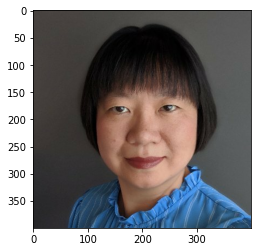

In [ ]:
test_image_original = load_image("h26CpAPb_400x400.jpg")
print(test_image_original.shape)
plt.imshow(test_image_original)
plt.show()

### Preprocess the image

In [ ]:
def resize(image):
    resized_image =  tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_image = tf.cast(resized_image, tf.float32)
    resized_image = tf.expand_dims(resized_image, 0)

    return resized_image

In [ ]:
test_image_resized = resize(test_image_original)
test_image_resized.shape

TensorShape([1, 256, 256, 3])

### Run inference on the preprocessed image

In [ ]:
with tf.io.gfile.GFile('selfie2anime.tflite', 'rb') as f:
    model_content = f.read()

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

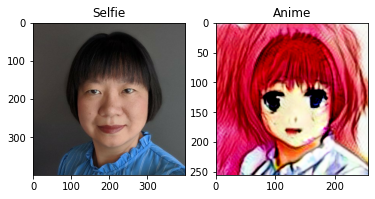

In [ ]:
# Set model input
interpreter.set_tensor(input_index, test_image_resized)

# Run inference
interpreter.invoke()

# Visualize results
plt.subplot(121)
plt.title('Selfie')
plt.imshow(test_image_original)

plt.subplot(122)
plt.title('Anime')
plt.imshow(output()[0])